In [1]:
from premise import *
import brightway2 as bw
bw.projects.set_current("ei39")

In [2]:
scenarios = [
    #{"model": "image", "pathway":"SSP1-RCP19", "year": 2050, "filepath":"/Users/romain/Documents"},
    {"model": "image", "pathway":"SSP2-Base", "year": 2050,},
    {"model": "image", "pathway":"SSP2-RCP26", "year": 2050,},
    {"model": "image", "pathway":"SSP2-RCP19", "year": 2050,},
    #{"model": "remind", "pathway":"SSP1-PkBudg500", "year": 2050,},
]

In [3]:
ndb = NewDatabase(
        scenarios = scenarios,
        source_db= "ecoinvent 3.9.1 cutoff",
        source_version="3.9.1",
        #source_type=source,
        #source_file_path=f"/Users/romain/Documents/ecoinvent {ei}_cutoff_ecoSpold02/datasets" if source == "ecospold" else None, # <-- this is NEW
        #source_version=ei,
        key='tUePmX_S5B8ieZkkM7WUU2CnO8SmShwmAeWK9x2rTFo=',
        #system_model="cutoff",
        #system_args=combinations[0]
)

premise v.(1, 5, 3)
+------------------------------------------------------------------+
| Warning                                                          |
+------------------------------------------------------------------+
| Because some of the scenarios can yield LCI databases            |
| containing net negative emission technologies (NET),             |
| it is advised to account for biogenic CO2 flows when calculating |
| Global Warming potential indicators.                             |
| `premise_gwp` provides characterization factors for such flows.  |
| It also provides factors for hydrogen emissions to air.          |
|                                                                  |
| Within your bw2 project:                                         |
| from premise_gwp import add_premise_gwp                          |
| add_premise_gwp()                                                |
+------------------------------------------------------------------+
+-------------

In [4]:
ndb.generate_scenario_report()

Generate scenario report.
Report saved under /Users/romain/GitHub/premise/dev/export/scenario_report.


In [4]:
ndb.scenarios[1]["iam data"].production_volumes.sel(region="USA", year=2050, variables=[
    "bioethanol, wood",
    "bioethanol, grass",
]).to_dataframe("val")

,region,year,val
variables,,,
"bioethanol, wood",USA,2050,0.16
"bioethanol, grass",USA,2050,0.21


In [90]:
years=ndb.scenarios[1]["iam data"].production_volumes.year.values
data = ndb.scenarios[1]["iam data"].production_volumes.to_dataframe("val").unstack()["val"].reset_index().melt(id_vars=["region", "variables"],value_vars=years)

In [91]:
data = data.loc[data["variables"].str.contains("bioethanol")]

In [112]:
data.loc[data["region"]==region].groupby(["year", "variables"]).sum().unstack()["value"].cumsum()/11.45*100

/var/folders/cn/pys1j9rn0y7djkhv3hfdtrs00000gn/T/ipykernel_6189/2255775072.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.loc[data["region"]==region].groupby(["year", "variables"]).sum().unstack()["value"].cumsum()/11.45*100


variables,"bioethanol, grain","bioethanol, grain, with CCS","bioethanol, grass","bioethanol, grass, with CCS","bioethanol, sugar","bioethanol, sugar, with CCS","bioethanol, wood","bioethanol, wood, with CCS"
year,,,,,,,,
2005,0.000000,0.0,0.000000,0.000000,1.397380,0.000000,0.000000,0.000000
2010,0.000000,0.0,0.000000,0.000000,5.414847,0.000000,0.000000,0.000000
2015,0.000000,0.0,0.000000,0.000000,10.480349,0.000000,0.000000,0.000000
2020,0.000000,0.0,0.000000,0.000000,15.633188,0.000000,0.000000,0.000000
2025,0.262009,0.0,0.087336,0.000000,21.921397,0.000000,0.174672,0.000000
2030,0.524017,0.0,0.349345,0.174672,34.061135,4.628821,0.436681,0.174672
2035,0.698690,0.0,0.873362,0.611354,45.327511,11.877729,0.960699,0.611354
2040,0.960699,0.0,1.921397,1.397380,52.838428,17.379913,1.746725,1.397380
2045,1.222707,0.0,3.318777,2.620087,56.943231,20.873362,2.794760,2.532751


In [111]:
(0.16+0.0+0.57+0.48+6.75+2.61+0.45+0.44)

11.459999999999999

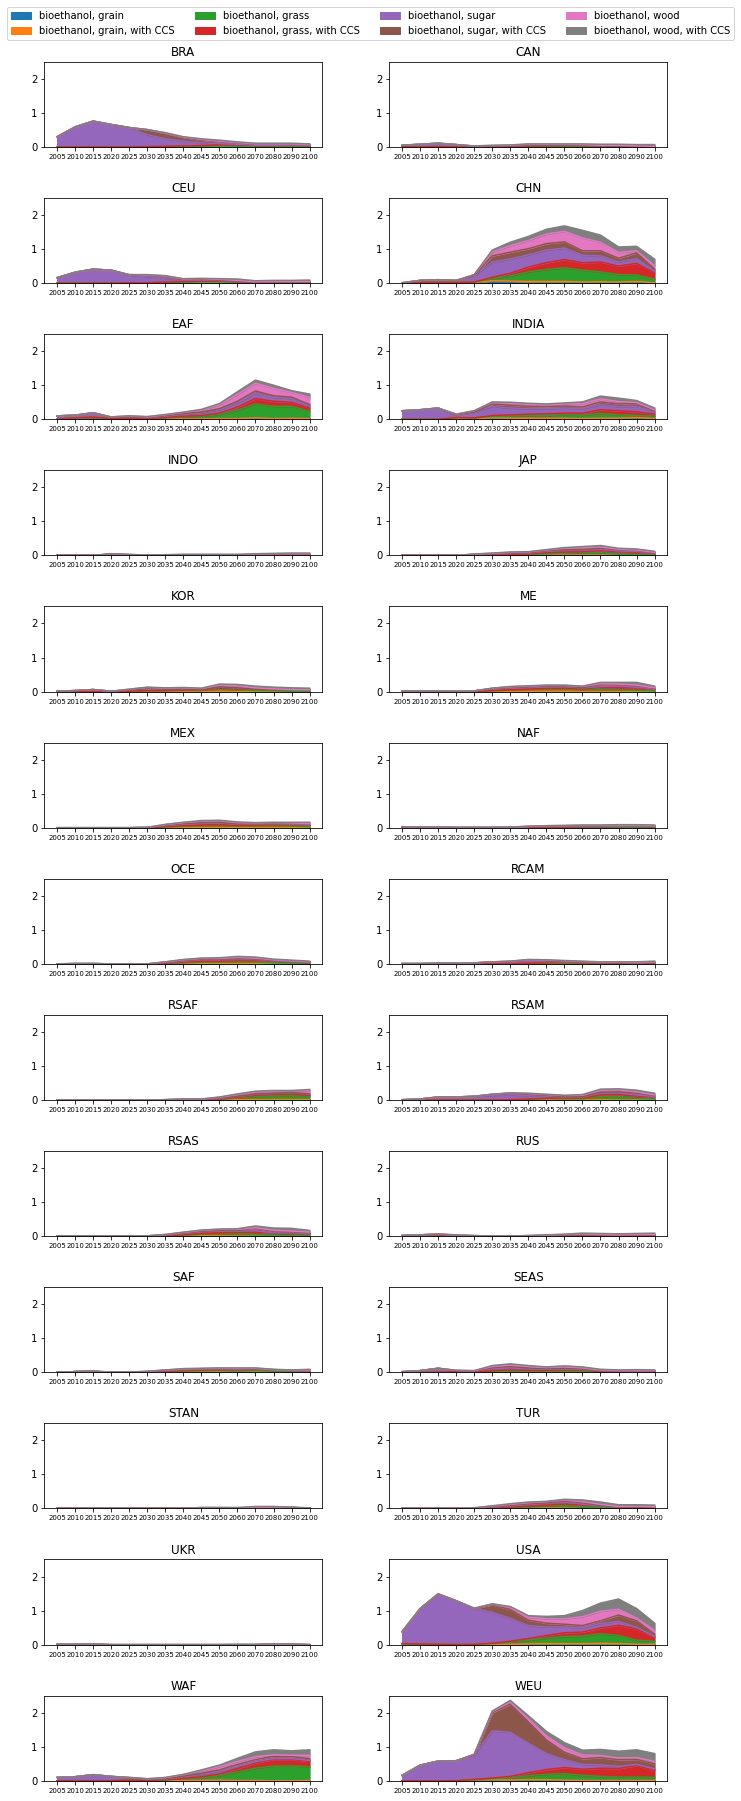

In [88]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(13, 2, figsize=(10, 25))  # create a grid of 5x6 subplots
fig.tight_layout(pad=3.0)  # add padding between subplots for clarity

# Flatten the array of axes to easily iterate over it
axs = axs.flatten()

for i, ax in enumerate(axs[:26]):
    region = data["region"].unique()[i]
    data.loc[data["region"]==region].groupby(["region", "year", "variables"]).sum().unstack()["value"].plot(kind="area", ax=ax)
    ax.set_title(region)
    ax.set_xlabel(None)
    ax.set_xticks(range(0, 15))
    ax.set_ylim(0, 2.5)
    ax.set_xticklabels([2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2060, 2070, 2080, 2090, 2100], fontsize=7)
    ax.legend(ncol=4, bbox_to_anchor=(2.5, 1.7))
    if i != 0:
        ax.legend().remove()
fig.savefig("/Users/romain/Library/CloudStorage/Dropbox/Notebooks/biofuels NREL-IMAGE/SSP2-RCP26.png", dpi=150, bbox_inches='tight')
        

In [4]:
from premise.activity_maps import InventorySet
inv = InventorySet(ndb.database, "3.9")

In [5]:
inv.generate_metals_map()

{'Dysprosium': {'Dysprosium'},
 'Neodymium': {'Neodymium, 4% in bastnasite, 0.4% in crude ore'},
 'Nickel': {'Nickel',
  'Nickel, 1.13% in sulfide, Ni 0.76% and Cu 0.76% in crude ore',
  'Nickel, 1.98% in silicates, 1.04% in crude ore',
  'Nickel, Ni 2.5E+0%, in mixed ore'},
 'Manganese': {'Manganese',
  'Manganese, 35.7% in sedimentary deposit, 14.2% in crude ore'},
 'Yttrium': {'Yttrium'},
 'Vanadium': {'Vanadium'},
 'Cobalt': {'Cobalt', 'Cobalt, Co 5.0E-2%, in mixed ore'},
 'Lithium': {'Lithium', 'Lithium, 0.15% in brine'},
 'Sulfur': {'Sulfur'},
 'Platinum': {'Platinum', 'Platinum, Pt 4.7E-7%, in mixed ore'},
 'Cerium': {'Cerium', 'Cerium, 24% in bastnasite, 2.4% in crude ore'},
 'Lanthanum': {'Lanthanum',
  'Lanthanum, 7.2% in bastnasite, 0.72% in crude ore'},
 'Zirconium': {'Zirconium', 'Zirconium, 50% in zircon, 0.39% in crude ore'},
 'Gadolinium': {'Gadolinium',
  'Gadolinium, 0.15% in bastnasite, 0.015% in crude ore'},
 'Scandium': {'Scandium'},
 'Strontium': {'Strontium'},
 '

In [6]:
inv.generate_powerplant_map()

{'Biomass CHP': {'heat and power co-generation, wood chips, 2000 kW',
  'heat and power co-generation, wood chips, 2000 kW, state-of-the-art 2014',
  'heat and power co-generation, wood chips, 6667 kW',
  'heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014',
  'heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014, renewable energy products'},
 'Biomass CHP CCS': {'electricity production, at co-generation power plant/wood, post, pipeline 200km, storage 1000m',
  'electricity production, at co-generation power plant/wood, post, pipeline 400km, storage 3000m'},
 'Biomass ST': {'electricity production, at wood burning power plant 20 MW, truck 25km, no CCS'},
 'Biomass IGCC CCS': {'electricity production, at BIGCC power plant, pre, pipeline 200km, storage 1000m',
  'electricity production, at wood burning power plant 20 MW, truck 25km, post, pipeline 200km, storage 1000m'},
 'Biomass IGCC': {'electricity production, at BIGCC power plant, no CCS'},
 

In [8]:
inv.generate_daccs_map()

{'dac_solvent': {'carbon dioxide, captured from atmosphere, with a solvent-based direct air capture system, 1MtCO2'},
 'dac_sorbent': {'carbon dioxide, captured from atmosphere, with a sorbent-based direct air capture system, 100ktCO2'},
 'daccs_solvent': {'carbon dioxide, captured from atmosphere and stored, with a solvent-based direct air capture system, 1MtCO2'},
 'daccs_sorbent': {'carbon dioxide, captured from atmosphere and stored, with a sorbent-based direct air capture system, 100ktCO2'}}

In [5]:
ndb.write_db_to_brightway("test_metals")

Write new database(s) to Brightway2.
Prepare database 1.
- check for duplicates...
One or multiple duplicates detected. Removing them...
- check for values format...
- relinking exchanges...
Done!


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31


Title: Writing activities to SQLite3 database:
  Started: 06/19/2023 12:11:07
  Finished: 06/19/2023 12:11:38
  Total time elapsed: 00:00:31
  CPU %: 86.50
  Memory %: 11.62
Created database: test_metals
Generate scenario report.
Report saved under /Users/romain/GitHub/premise/dev/export/scenario_report.
Generate change report.
Report saved under /Users/romain/GitHub/premise/dev.


In [ ]:
products = [
    'lightweighting, glider',
    'auxilliary battery inputs, for road vehicle',
    'battery cell, Li-ion, NMC622',
    'auxilliary electronics inputs, for fuel cell electric vehicle',
    'auxilliary material inputs, for fuel cell electric vehicle',
    'fuel cell stack, for fuel cell electric vehicle',
    'carbon fiber, weaved',
    'tank liner, polyethylene, high density',
    'transformer and rectifier unit, for electrolyser',
    'fuel tank, for diesel road vehicle',
    'fuel tank, for compressed hydrogen gas, 700bar',
    'fuel tank, for compressed hydrogen gas, 700bar',
    'fuel tank, for compressed hydrogen gas, 700bar',
    'fuel tank, for compressed natural gas, 200 bar',
    'charger, level 3, plugin, 200 kW, for electric vehicle',
    'gearbox, for lorry',
    'transmission, for lorry',
    'suspension, for lorry',
    'power electronics, for lorry',
    'auxilliary material inputs, for electric lorry',
    'retarder, for lorry',
    'cabin, for lorry',
    'frame, blanks and saddle, for lorry',
    'tires and wheels, for lorry',
    'auxilliary material inputs, for hydrid electric lorry',
    'exhaust system, for lorry',
    'internal combustion engine, for lorry',
    'lead acid battery, for lorry',
    'charger, level 3, with pantograph, 450 kW, for electric vehicle',
    'overhead lines, for electric vehicle',
    'battery cell, Li-ion, LTO',
    'charging station, 3kW',
    'battery cell,  Li-ion, LFP',
    'battery cell, Li-ion, NCA',
    'assembly operation, for lorry'
]

print(len(products))

acts = [a for a in bw.Database("brian") if a["reference product"] in products]

In [ ]:
len(acts)

In [ ]:
[a["reference product"] for a in acts]

In [ ]:
import bw2data
bw2io.BW2Package.export_obj(obj=bw.Database("brian"), filename="db_for_brian.bw2package")

In [ ]:
import bw2data
bw2io.BW2Package.import_file("db_for_brian.bw2package")

In [ ]:
fp = "/Users/romain/Library/Application Support/Brightway3/ei39.f1469ad5eb0a071dc60323f6e0fce980/output/lci-brian.xlsx"
import bw2io

i = bw2io.ExcelImporter(fp)
i.apply_strategies()

In [ ]:
ei_acts = list(set([(a["name"], a["reference product"]) for a in bw.Database("ecoinvent 3.9.1 cutoff")]))
print(len(ei_acts))

In [ ]:
for ds in i.data:
    if (ds["name"], ds["reference product"]) in ei_acts:
        i.data.remove(ds)

In [ ]:
for ds in i.data:
    if (ds["name"], ds["reference product"]) not in ei_acts:
        print(ds["name"])

In [ ]:
len(i.data)

In [ ]:
for ds in i.data:
    print(ds["name"])

In [ ]:
i.match_database(fields=["name", "unit", "location"])
i.match_database("ecoinvent 3.9.1 cutoff", fields=["name", "reference product", "location", "unit"])
i.match_database("biosphere3", fields=["name", "categories", "unit"])

In [ ]:
i.statistics()

In [ ]:
list(i.unlinked)[-1]

In [ ]:
bw.get_activity(('brian', '360c5e612a154ebb8cee2650bcc1bc75_copy1'))

In [ ]:
for f in bw.Database("biosphere3"):
    if f["code"] == "e030108f-2125-4bcb-a73b-ad72130fcca3":
        print(f)

In [ ]:
bw.projects.set_current("ei39")

In [ ]:
l = []

for f in bw.Database("biosphere3"):
    l.append([f["name"], f["categories"][0], f["categories"][1] if len(f["categories"])>1 else "unspecified", f["unit"], f["code"]])

In [ ]:
import csv

with open("flows_biosphere_39.csv", "w", newline="", ) as f:
    writer = csv.writer(f, delimiter=";")
    writer.writerows(l)

In [ ]:
ndb.scenarios[1]["iam data"].fuel_markets.sel(region="NEU").variables.values

In [ ]:
import numpy as np
for ds in ndb.scenarios[1]["database"]:
    if ds["name"] == ("carbon dioxide, captured from atmosphere, with a solvent-based direct air capture system, 1MtCO2, with waste heat, and grid electricity",
                            "carbon dioxide, captured from atmosphere"):
            print(ds["name"], ds["location"])

In [ ]:
for ds in ndb.scenarios[1]["database"]:
    if "carbon dioxide, captured" in ds["name"]:
        print(ds["name"], ds["location"])

In [ ]:
ndb.scenarios[0]["iam data"].fuel_markets.sel(region="WEU", year=2050)

In [ ]:
ndb.scenarios[0]["iam data"].fuel_markets.sel(region="WEU")

In [ ]:
ndb.update_electricity()

In [ ]:
ndb.scenarios[0]["iam data"].fuel_markets

In [ ]:
ndb.generate_scenario_report()

In [ ]:
ndb.generate_change_report()

In [ ]:
ndb.update_all()

In [ ]:
ndb.generate_scenario_report()

In [ ]:
ndb.generate_change_report()

In [ ]:
ndb.scenarios[0]["iam data"].gains_data_IAM

In [ ]:
ndb.update_all()

In [ ]:
ndb.write_db_to_brightway(["test_dac", "test_dac2"])

In [ ]:
from premise.geomap import Geomap

In [ ]:
Geomap()

In [ ]:
Geomap(model="remind").geo.keys()

In [ ]:
ndb.scenarios[0]["iam data"].carbon_capture_rate.sel(variables="steel")

In [ ]:
for ds in ndb.scenarios[0]["database"]:
    for e in ds["exchanges"]:
        if e["name"].startswith("CO2 capture, at cement production plant"):
            print(e["name"], e.get("location"), e["amount"])
            print(ds["name"])
            print("--------------------")